In [128]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import pandas as pd
import common
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose
)
import numpy as np
from keras.applications.resnet50 import preprocess_input, ResNet50
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.layers import Input, InputLayer, Dense, Lambda, Concatenate
from keras import backend as K
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import f1_score
from scipy.optimize import minimize_scalar
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('../input/train.csv')
df.columns = ['image', 'id']
df.head()

,image,id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [3]:
VECTOR_SIZE = 300

In [4]:
def pair_mapping(df):
    df_anchor = df.sort_values(['id', 'image'], ascending=[True, True]).reset_index(drop=True).add_suffix('_anchor')
    df_positive = df.sort_values(['id', 'image'], ascending=[True, False]).reset_index(drop=True).add_suffix('_positive')
    df_negative = df.sort_values(['id', 'image'], ascending=[False, False]).reset_index(drop=True).add_suffix('_negative')
    df_triplet = df_anchor.join(df_positive).join(df_negative)
    df_triplet = df_triplet.loc[
        (df_triplet['id_anchor'] == df_triplet['id_positive']) &
        (df_triplet['id_anchor'] != df_triplet['id_negative'])
    ].reset_index(drop=True)
    return df_triplet

In [5]:
def shuffled_unique_ids(df):
    ids = df.loc[df['id'] != 'new_whale', 'id'].drop_duplicates()
    return ids.sample(len(ids)).reset_index(drop=True)

In [6]:
len(df['id'].unique())

5005

In [7]:
ids = shuffled_unique_ids(df)
train_ids = ids[:4500]
val_ids = ids[4500:]

In [8]:
train_mapping = pair_mapping(df.loc[df['id'].isin(train_ids)])
val_mapping = pair_mapping(df.loc[df['id'].isin(val_ids)])

In [9]:
train_mapping.shape

(14098, 6)

In [10]:
val_mapping.shape

(1592, 6)

In [38]:
images = common.read_pickle('../data/train-images.pkl')

In [12]:
train_mapping.head()

,image_anchor,id_anchor,image_positive,id_positive,image_negative,id_negative
0,833675975.jpg,w_0003639,833675975.jpg,w_0003639,df4bbd82a.jpg,w_ffe8693
1,2fe2cc5c0.jpg,w_0003c59,2fe2cc5c0.jpg,w_0003c59,d3967e1df.jpg,w_ffcf5fe
2,2f31725c6.jpg,w_0027efa,ee87a2369.jpg,w_0027efa,9dd320bb3.jpg,w_ffa6d42
3,30eac8c9f.jpg,w_0027efa,cc6c1a235.jpg,w_0027efa,5ac086036.jpg,w_ff94900
4,3c4235ad2.jpg,w_0027efa,c5658abf0.jpg,w_0027efa,6404e5b70.jpg,w_ff7a4ae


In [13]:
train_mapping.loc[train_mapping['image_anchor'] != train_mapping['image_positive']].head()

,image_anchor,id_anchor,image_positive,id_positive,image_negative,id_negative
2,2f31725c6.jpg,w_0027efa,ee87a2369.jpg,w_0027efa,9dd320bb3.jpg,w_ffa6d42
3,30eac8c9f.jpg,w_0027efa,cc6c1a235.jpg,w_0027efa,5ac086036.jpg,w_ff94900
4,3c4235ad2.jpg,w_0027efa,c5658abf0.jpg,w_0027efa,6404e5b70.jpg,w_ff7a4ae
5,47bd1d3bb.jpg,w_0027efa,b2acbd8df.jpg,w_0027efa,9389e3865.jpg,w_ff65f67
6,5934e01ea.jpg,w_0027efa,7b9a5e4d8.jpg,w_0027efa,d5ce140aa.jpg,w_ff5fc91


In [14]:
def strong_aug(p=0.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)

In [15]:
def get_batch_count(triplet_mapping, batch_size):
    return int(math.ceil(len(triplet_mapping) / batch_size))

In [16]:
def triplet_generator(triplet_mapping, batch_size):
    augmenter = strong_aug()
    always_augmenter = strong_aug(p=1.0)
    while True:
        for batch in range(get_batch_count(triplet_mapping, batch_size)):
            anchor_fnames = triplet_mapping['image_anchor'].values[batch * batch_size : (batch + 1) * batch_size]
            positive_fnames = triplet_mapping['image_positive'].values[batch * batch_size : (batch + 1) * batch_size]
            negative_fnames = triplet_mapping['image_negative'].values[batch * batch_size : (batch + 1) * batch_size]
            X = []
            for anchor_fname, positive_fname, negative_fname in zip(anchor_fnames, positive_fnames, negative_fnames):
                anchor_image = images[anchor_fname]
                positive_image = images[positive_fname]
                negative_image = images[negative_fname]
                if anchor_fname == positive_fname:
                    positive_image = always_augmenter(image=positive_image)['image']
                    negative_image = augmenter(image=negative_image)['image']
                else:
                    anchor_image = augmenter(image=anchor_image)['image']
                    positive_image = augmenter(image=positive_image)['image']
                    negative_image = augmenter(image=negative_image)['image']
                X.append((anchor_image, positive_image, negative_image))
            X_keras = [
                preprocess_input(np.array([item[input_idx] for item in X]))
                for input_idx in range(3)
            ]
            y = np.zeros([X_keras[0].shape[0], 1])
            yield X_keras, y

In [17]:
class L2Normalize(Lambda):
    def __init__(self, eps=1e-8):
        super(L2Normalize, self).__init__(lambda X: L2Normalize.l2_normalize(X, eps))
    
    @staticmethod
    def l2_normalize(X, eps):
        l2_norm = K.sqrt(K.sum(X ** 2, axis=-1))
        return X / (K.reshape(l2_norm, (-1, 1)) + eps)

In [18]:
resnet = ResNet50(include_top=False, weights='imagenet', pooling='max')
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [19]:
def customized_std(X, eps):
    return K.sqrt(K.var(X) + eps)

def triplet_loss(y_true, y_pred):
    y_anchor = 5 * y_pred[:, :VECTOR_SIZE]
    y_positive = 5 * y_pred[:, VECTOR_SIZE:2*VECTOR_SIZE]
    y_negative = 5 * y_pred[:, 2*VECTOR_SIZE:]
    pos_diff = y_positive - y_anchor
    neg_diff = y_negative - y_anchor
    pos_dist = K.sum(pos_diff ** 2, axis=-1)
    neg_dist = K.sum(neg_diff ** 2, axis=-1)
    pos_loss = pos_dist + K.var(pos_diff)
    neg_loss = -neg_dist + K.var(neg_diff)
    loss = pos_loss + neg_loss + 1.0
    loss = K.maximum(loss, 0.0)
    return loss

In [20]:
class MonitorCallback(Callback):
    def __init__(self, val_data_size, val_data_generator):
        super(MonitorCallback, self).__init__()
        self.val_data_size = val_data_size
        self.val_data_generator = val_data_generator
    
    def on_epoch_end(self, *args, **kwargs):
        print('')
        print('Building validation prediction')
        val_pred = self.model.predict_generator(self.val_data_generator, self.val_data_size, verbose=True)
        val_anchor = val_pred[:, :VECTOR_SIZE]
        val_positive = val_pred[:, VECTOR_SIZE:2*VECTOR_SIZE]
        val_negative = val_pred[:, 2*VECTOR_SIZE:]
        pos_dist = np.sqrt(((val_positive - val_anchor)**2).sum(axis=-1))
        neg_dist = np.sqrt(((val_negative - val_anchor)**2).sum(axis=-1))
        print('Positive distance: mean={0}, std={1}'.format(np.mean(pos_dist), np.std(pos_dist)))
        print('Negative distance: mean={0}, std={1}'.format(np.mean(neg_dist), np.std(neg_dist)))
        print('')

In [21]:
inputs = [Input(shape=(224, 224, 3)) for _ in range(3)]
features = [resnet(input) for input in inputs]
fc_layer = Dense(VECTOR_SIZE)
fc_features = [fc_layer(features_vec) for features_vec in features]
l2_normed = [L2Normalize()(fc_features_vec) for fc_features_vec in fc_features]
concat = Concatenate(axis=-1)(l2_normed)
model = Model(inputs, concat)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 2048)         23587712    input_2[0][0]                    
                                                                 input_3[0][0]                    
          

In [22]:
resnet.trainable = False

In [23]:
model.compile(loss=triplet_loss, optimizer=SGD(lr=0.001))

In [24]:
model.fit_generator(triplet_generator(train_mapping, 8),
                    get_batch_count(train_mapping, 8),
                    validation_data=triplet_generator(val_mapping, 8),
                    validation_steps=get_batch_count(val_mapping, 8),
                    callbacks=[
                        MonitorCallback(
                            get_batch_count(val_mapping.loc[val_mapping['image_positive'] != val_mapping['image_anchor']], 8),
                            triplet_generator(val_mapping.loc[val_mapping['image_positive'] != val_mapping['image_anchor']], 8),
                        ),
                        ModelCheckpoint('model.h5', save_best_only=True),
                    ],
                    epochs=10)

Epoch 1/10
1763/1763 [==============================] - 483s 274ms/step - loss: 0.8289 - val_loss: 0.5851

Building validation prediction
161/161 [==============================] - 44s 272ms/step
Positive distance: mean=0.46410560607910156, std=0.05657998099923134
Negative distance: mean=0.5117529630661011, std=0.05382446572184563

Epoch 2/10
1763/1763 [==============================] - 471s 267ms/step - loss: 0.6912 - val_loss: 0.4910

Building validation prediction
161/161 [==============================] - 41s 257ms/step
Positive distance: mean=0.4522697329521179, std=0.05596580728888512
Negative distance: mean=0.5093664526939392, std=0.06060449033975601

Epoch 3/10
1763/1763 [==============================] - 472s 268ms/step - loss: 0.6407 - val_loss: 0.4630

Building validation prediction
161/161 [==============================] - 42s 259ms/step
Positive distance: mean=0.4516405463218689, std=0.05780577287077904
Negative distance: mean=0.5176411867141724, std=0.06627438217401505



In [70]:
whale2vec = Sequential([
    InputLayer((224, 224, 3)),
    resnet,
    model.layers[4],
    L2Normalize()
])
whale2vec.compile(optimizer=SGD(), loss='mse')
whale2vec.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 300)               614700    
_________________________________________________________________
l2_normalize_4 (L2Normalize) (None, 300)               0         
Total params: 24,202,412
Trainable params: 15,064,876
Non-trainable params: 9,137,536
_________________________________________________________________


In [71]:
def iterate_images(images, fnames, batch_size):
    while True:
        for batch in range(get_batch_count(fnames, batch_size)):
            batch_fnames = fnames[batch * batch_size : (batch + 1) * batch_size]
            batch_images = np.array([images[fname] for fname in batch_fnames])
            yield preprocess_input(batch_images)

In [72]:
val_mapping['vec_anchor'] = list(whale2vec.predict_generator(
    iterate_images(images, val_mapping['image_anchor'].values, 8),
    get_batch_count(val_mapping['image_anchor'].values, 8),
    verbose=True
))
val_mapping['vec_positive'] = list(whale2vec.predict_generator(
    iterate_images(images, val_mapping['image_positive'].values, 8),
    get_batch_count(val_mapping['image_positive'].values, 8),
    verbose=True
))
val_mapping['vec_negative'] = list(whale2vec.predict_generator(
    iterate_images(images, val_mapping['image_negative'].values, 8),
    get_batch_count(val_mapping['image_negative'].values, 8),
    verbose=True
))

199/199 [==============================] - 18s 90ms/step


In [73]:
val_mapping['dist_positive'] = val_mapping.apply(lambda row: np.sqrt( ((row['vec_anchor'] - row['vec_positive']) ** 2).sum() ),
                                                 axis=1)
val_mapping['dist_negative'] = val_mapping.apply(lambda row: np.sqrt( ((row['vec_anchor'] - row['vec_negative']) ** 2).sum() ),
                                                 axis=1)

/home/user/.conda/envs/whales/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


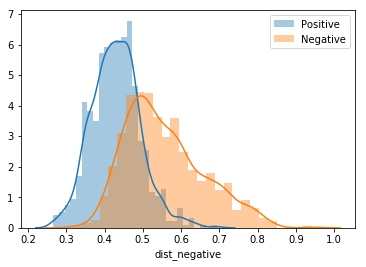

In [74]:
sns.distplot(val_mapping.loc[val_mapping['image_positive'] != val_mapping['image_anchor'], 'dist_positive'], label='Positive')
sns.distplot(val_mapping['dist_negative'], label='Negative')
plt.legend()

In [75]:
train_mapping['vec_anchor'] = list(whale2vec.predict_generator(
    iterate_images(images, train_mapping['image_anchor'].values, 8),
    get_batch_count(train_mapping['image_anchor'].values, 8),
    verbose=True
))
train_mapping['vec_positive'] = list(whale2vec.predict_generator(
    iterate_images(images, train_mapping['image_positive'].values, 8),
    get_batch_count(train_mapping['image_positive'].values, 8),
    verbose=True
))
train_mapping['vec_negative'] = list(whale2vec.predict_generator(
    iterate_images(images, train_mapping['image_negative'].values, 8),
    get_batch_count(train_mapping['image_negative'].values, 8),
    verbose=True
))

1763/1763 [==============================] - 158s 90ms/step


In [76]:
train_mapping['dist_positive'] = train_mapping.apply(lambda row: np.sqrt( ((row['vec_anchor'] - row['vec_positive']) ** 2).sum() ),
                                                 axis=1)
train_mapping['dist_negative'] = train_mapping.apply(lambda row: np.sqrt( ((row['vec_anchor'] - row['vec_negative']) ** 2).sum() ),
                                                 axis=1)

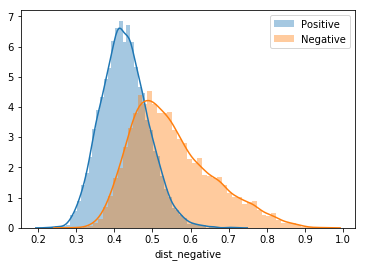

In [77]:
sns.distplot(train_mapping.loc[train_mapping['image_positive'] != train_mapping['image_anchor'], 'dist_positive'], label='Positive')
sns.distplot(train_mapping['dist_negative'], label='Negative')
plt.legend()

In [78]:
images_vectors = whale2vec.predict_generator(
    iterate_images(images, sorted(images.keys()), 8),
    get_batch_count(images.keys(), 8),
    verbose=True
)
image2index = {fname: index for index, fname in enumerate(sorted(images.keys()))}

3171/3171 [==============================] - 285s 90ms/step


In [82]:
fnames = np.array(sorted(images.keys()))
ids = df.set_index('image')['id'][fnames].values

In [85]:
X_known = euclidean_distances(images_vectors[ids != 'new_whale'], images_vectors[ids != 'new_whale'])
X_known.shape

/home/user/.conda/envs/whales/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


(15697, 15697)

In [87]:
X_unknown = euclidean_distances(images_vectors[ids == 'new_whale'], images_vectors[ids != 'new_whale'])
X_unknown.shape

(9664, 15697)

In [93]:
X_known[X_known == 0] = np.inf

/home/user/.conda/envs/whales/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


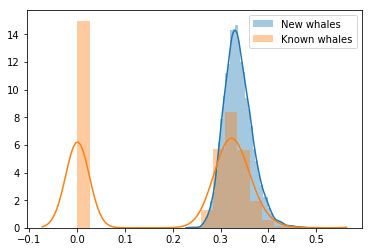

In [97]:
sns.distplot(X_unknown.min(axis=1), label='New whales')
sns.distplot(X_known.min(axis=1), label='Known whales')
plt.legend()

In [124]:
X = np.hstack([X_known.min(axis=1), X_unknown.min(axis=1)])
y = np.hstack([np.zeros(len(X_known)), np.ones(len(X_unknown))])

In [125]:
threshold_search = minimize_scalar(lambda thr: -f1_score(1.0 * (X > thr), y),
                                   bounds=(0.0, 1.0),
                                   method='bounded')
threshold_search

/home/user/.conda/envs/whales/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


     fun: -0.6727909011373577
 message: 'Solution found.'
    nfev: 26
  status: 0
 success: True
       x: 0.2916430514927032

In [126]:
f1_score(1.0 * (X > threshold_search.x), y)

0.6727909011373577

In [127]:
test_images = common.read_pickle('../data/test-images.pkl')

In [153]:
knn = KNeighborsClassifier(250, metric='euclidean')
knn.fit(images_vectors, ids)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=250, p=2,
           weights='uniform')

In [154]:
test_images_vectors = whale2vec.predict_generator(
    iterate_images(test_images, sorted(test_images.keys()), 8),
    get_batch_count(test_images.keys(), 8),
    verbose=True
)
test_image2index = {fname: index for index, fname in enumerate(sorted(test_images.keys()))}

995/995 [==============================] - 89s 90ms/step


In [155]:
neighbours = knn.kneighbors(test_images_vectors)

In [156]:
distances, indices = neighbours

In [157]:
neighbouds_ids = np.array([ids[idx] for idx in indices.ravel()]).reshape(indices.shape)
neighbouds_ids[:2]

array([['new_whale', 'w_41d24c6', 'new_whale', 'new_whale', 'w_69b5ace',
        'w_d72771c', 'w_c63fd83', 'w_e36b021', 'w_0ee9ae5', 'w_d72771c',
        'w_d907b6c', 'w_0369a5c', 'new_whale', 'new_whale', 'w_f314516',
        'w_04003e9', 'w_3cd4d35', 'w_41d24c6', 'w_5a3e0de', 'w_ee57fc5',
        'new_whale', 'w_dd88965', 'w_39141fc', 'w_0d052c1', 'w_ae393cd',
        'w_0e9f07a', 'w_41d24c6', 'w_5d6ba39', 'w_69b5ace', 'w_bb2c919',
        'w_0cbf1b3', 'new_whale', 'w_b128587', 'w_db2d2ac', 'w_41d24c6',
        'w_1bd2d91', 'w_4312b77', 'new_whale', 'w_700ebb4', 'w_c536a4a',
        'w_69c8945', 'new_whale', 'new_whale', 'w_bb2c919', 'w_d72771c',
        'w_b60f441', 'w_aa0bd3b', 'w_d602efb', 'w_cad4b47', 'w_ec7f1b3',
        'w_2b17316', 'w_5612025', 'new_whale', 'w_5d6ba39', 'w_ce44322',
        'new_whale', 'w_2548d54', 'w_fd6a3ad', 'new_whale', 'w_cac9bdb',
        'w_d9cdc09', 'w_2365d55', 'new_whale', 'new_whale', 'w_c1efffb',
        'w_d223b2e', 'w_23a388d', 'w_4e87672', 'w_c

In [158]:
def ordered_top_items(ids, count):
    items = []
    for i in ids:
        if i not in items:
            items.append(i)
    items = items[:count]
    return np.array(items)

In [159]:
ordered_top_items(neighbouds_ids[0], 5)

array(['new_whale', 'w_41d24c6', 'w_69b5ace', 'w_d72771c', 'w_c63fd83'],
      dtype='<U9')

In [160]:
neighbouds_ids_cleaned = np.array([
    ordered_top_items(row, 5)
    for row in neighbouds_ids
])

In [162]:
neighbouds_ids_cleaned.shape

(7960, 5)

In [172]:
def classes(distances, classes):
    if distances.min() > threshold_search.x:
        classes = ['new_whale'] + list(classes)
    classes = ordered_top_items(classes, 5)
    return np.array(classes)

In [173]:
predicted_classes = np.array([
    classes(dist, idxs)
    for dist, idxs in zip(distances, neighbouds_ids_cleaned)
])

In [175]:
prediction = pd.DataFrame([
    [fname] + [' '.join(list(predicted_classes[test_image2index[fname]]))]
    for fname in sorted(test_image2index.keys())
])
prediction.head()

,0,1
0,00028a005.jpg,new_whale w_41d24c6 w_69b5ace w_d72771c w_c63fd83
1,000dcf7d8.jpg,new_whale w_2b17316 w_6aab519 w_61e4690 w_0c76541
2,000e7c7df.jpg,new_whale w_15951db w_dd837b1 w_6bab2bd w_f3252ff
3,0019c34f4.jpg,w_d71a790 w_34ecf36 w_9c506f6 w_23e1d57 w_46c4c49
4,001a4d292.jpg,new_whale w_aaf3463 w_4a12050 w_281a8cd w_4096187


In [176]:
prediction.columns = ['Image', 'Id']
prediction.head()

,Image,Id
0,00028a005.jpg,new_whale w_41d24c6 w_69b5ace w_d72771c w_c63fd83
1,000dcf7d8.jpg,new_whale w_2b17316 w_6aab519 w_61e4690 w_0c76541
2,000e7c7df.jpg,new_whale w_15951db w_dd837b1 w_6bab2bd w_f3252ff
3,0019c34f4.jpg,w_d71a790 w_34ecf36 w_9c506f6 w_23e1d57 w_46c4c49
4,001a4d292.jpg,new_whale w_aaf3463 w_4a12050 w_281a8cd w_4096187


In [177]:
prediction.to_csv('output.csv', index=None)